# Chapter 7

## Cross-Validation in Finance

### Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, log_loss, accuracy_score
import copy
from statsmodels.tsa.stattools import adfuller

In [2]:
def getDailyVol(close, span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=(pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:]))
    
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1  # daily rets
        
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
        
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    
    return df0

In [3]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0,sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -h:
            sNeg=0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
        
    return pd.DatetimeIndex(tEvents)    

In [4]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1<close.shape[0]]
    t1 = (pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [5]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1 get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt>minRet]  # minRet
    
    #2 get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
        
    #3) form events object, apply stop loss on t1
    if side is None:
        side_,ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_,ptSl_ = side.loc[trgt.index],ptSl[:2]
    
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_},axis=1).dropna(subset=['trgt']))
    
    df0 = mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), numThreads=numThreads, 
                     close=close, events=events, ptSl=ptSl)
    
    events['t1']=df0.dropna(how='all').min(axis=1)  # pd.min ignores nan
    if side is None: 
        events = events.drop('side',axis=1)
    
    return events   
    
    
    

def getEvents2(close, tEvents, ptSl, trgt, minRet, t1=False, side=None):
    #1 get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt>minRet]  # minRet
    
    #2 get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
        
    #3) form events object, apply stop loss on t1
    if side is None:
        side_,ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_,ptSl_ = side.loc[trgt.index],ptSl[:2]
    
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_},axis=1).dropna(subset=['trgt']))
    
    molecule = events.index
    df0 = applyPtSlOnT1(close, events, ptSl, molecule)
       
    #df0 = mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), numThreads=numThreads, 
    #                 close=close, events=events, ptSl=ptSl)
    
    events['t1']=df0.dropna(how='all').min(axis=1)  # pd.min ignores nan
    if side is None: 
        events = events.drop('side',axis=1)
    
    return events  




def applyPtSlOnT1(close,events,ptSl,molecule):
    
    # apply profit taking / stop loss if it takes place before t1 (end of event)
    
    events_ = events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    
    if ptSl[0]>0:
        pt=ptSl[0]*events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs
        
    if ptSl[1]>0:
        sl = -ptSl[1]*events_['trgt']
    else:
        sl = pd.Series(index=events.index)  #NaNs
    
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]   # path prices
        df0 = (df0/close[loc]-1) * events_.at[loc,'side']  # path returns
        out.loc[loc,'sl'] = df0[df0 < sl[loc]].index.min()   # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking
    
    return out

In [6]:
def getBins(events, close):
    """
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    events['trgt'] is event's target
    -events['side] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (.1,1) <- label by price action
    Case 2: ('side' in events): bin in (0,1) <- label by pnl (meta-labeling)
    """
    
    #1 prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    #2 create out object 
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    
    out['bin'] = np.sign(out['ret'])
    
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0   # meta-labeling
    
    return out

In [7]:
# Auto-correlation:
# These functions have been taken from the github BlackArbsCEO/Adv_Fin_ML_Exercises by Brian Chistopher - Blackarbs

def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a Dataframe"""
    return (df.rolling(window=window).corr(df.shift(lag)))


In [8]:
#SNIPPET 7.1 PURGING OBSERVATION IN THE TRAINING SET

def getTrainTimes(t1,testTimes):
    '''
    Given testTimes, find the times of the training observations.
    —t1.index: Time when the observation started.
    —t1.value: Time when the observation ended.
    —testTimes: Times of testing observations.
    '''
    trn=t1.copy(deep=True)
    
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index     # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index                 # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index           # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

In [9]:
# SNIPPET 7.2 EMBARGO ON TRAINING OBSERVATIONS
def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg

In [10]:
#SNIPPET 7.3 CROSS-VALIDATION CLASS WHEN OBSERVATIONS OVERLAP

from sklearn.model_selection._split import _BaseKFold

class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    '''
    
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        
        if not isinstance(t1, pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
            
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    
    
    def split(self,X,y=None,groups=None):
        
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
            
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)]
        
        for i,j in test_starts:
            
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:]))
                
            yield train_indices,test_indices
            
            

In [11]:
#SNIPPET 7.4 USING THE PurgedKFold CLASS

def cvScore(clf, X, y, sample_weight, scoring='neg_log_loss', t1=None, cv=None, cvGen=None, pctEmbargo=None):
    
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    
    from sklearn.metrics import log_loss,accuracy_score
    #from clfSequential import PurgedKFold
    
    
    if cvGen is None:
        
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    
    '''
    if cvGen is None:
        if pctEmbargo==None:
            cvGen = PurgedKFold(n_splits=cv, t1=t1)
    else:
            cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    '''
    
    score=[]
    
    for train,test in cvGen.split(X=X):    # book
            
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values) # book
        
        #fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train].values.reshape(-1),\
        #            sample_weight=sample_weight.iloc[train].values.reshape(-1))   # mc
        
        
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[test,:])
            score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[test,:])
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values)
            
        score.append(score_)
        
    return np.array(score)


# ----------------------- --------------------- ------------------------- ---------------------------


def cvScore2_mc(clf, X, y, sample_weight, scoring='neg_log_loss', t1=None, cv=None, cvGen=None, pctEmbargo=None):
    
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    
    from sklearn.metrics import log_loss,accuracy_score
    #from clfSequential import PurgedKFold
    
    if cvGen is None:                                   # mc
        if pctEmbargo==None:                            # mc
            cvGen = PurgedKFold(n_splits=cv, t1=t1)     # mc
        else:
            cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged , book
    
    score=[]
    
    for train,test in cvGen.split(X=X):    
            
        #fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values) # book
        
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train].values.reshape(-1),\
                    sample_weight=sample_weight.iloc[train].values.reshape(-1))   # mc
        
        
        
        
        if scoring=='neg_log_loss':
            
            prob=fit.predict_proba(X.iloc[test,:])
            
            #score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
            score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values.reshape(-1),labels=clf.classes_)
            
        else:
            pred=fit.predict(X.iloc[test,:])
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values)
            
        score.append(score_)
        
    return np.array(score)
  



In [12]:
def cvScore_shuffled(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None,pctEmbargo=None):
    
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    
    from sklearn.metrics import log_loss,accuracy_score
    #from clfSequential import PurgedKFold
    from sklearn.model_selection import KFold
    
    #if cvGen is None:
    #    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
        
    score=[]
    
    features_shuffled = features.sample(frac=1)
    
    #X = X.sample(frac=1)
    #y = y.loc[X.index]
    t1 = t1.loc[X.index]
    
    kf = KFold(n_splits=cv, shuffle=True)       # This is the line where the "shuffle" takes place
    
    
    for train,test in kf.split(X):    
            
        #fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values) # book
        
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train].values.reshape(-1),\
                    sample_weight=sample_weight.iloc[train].values.reshape(-1))   # mc
        
        
        
        
        if scoring=='neg_log_loss':
            
            prob=fit.predict_proba(X.iloc[test,:])
            
            #score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
            score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values.reshape(-1),labels=clf.classes_)
            
        else:
            pred=fit.predict(X.iloc[test,:])
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values)
            
        score.append(score_)
        
    return np.array(score)

In [13]:
def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    
    #2) Apply weights to values
    df={}
    
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            
            if not np.isfinite(series.loc[loc1,name]):
                continue # exclude NAs
                
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
            
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [14]:
def getWeights_FFD(d, thres):
    # thres>0 drops insignificant weights
    w, k = [1.], 1
    
    while True:
        
        w_ = -w[-1]/k * (d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    w=np.array(w[::-1]).reshape(-1,1)
    
    return w  

In [15]:
def getDailyVol(close, span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=(pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:]))
    
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1  # daily rets
        
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
        
    #df0=df0.ewm(span=span0).std().rename('dailyVol')
    df0=df0.ewm(span=span0).std()
    df0.columns = ['dailyVol']
    
    return df0

In [16]:
# SNIPPET 2.4 - THE SYMMETRIC CUSUM FILTER

def getTEvents(gRaw,h):
    
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
            
        elif sPos>h:
            sPos=0;tEvents.append(i)
            
    return pd.DatetimeIndex(tEvents)

In [17]:
def getTEvents2(gRaw,h):
    
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    up_dates = []
    down_dates = []
    
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
            down_dates.append(i)
            
        elif sPos>h:
            sPos=0;tEvents.append(i)
            up_dates.append(i)
            
    return pd.DatetimeIndex(tEvents), up_dates, down_dates

In [18]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count.
    '''

    #1) find events that span the period [molecule[0],molecule[-1]]
    
    t1=t1.fillna(closeIdx[-1])       # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]]           # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()]   # events that start at or before t1[molecule].max()
    
    #2) count events spanning a bar
    
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    
    return count.loc[molecule[0]:t1[molecule].max()]

    
    

In [19]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    
    return wght.abs()

# out['w']*=out.shape[0]/out['w'].sum()

In [20]:
def getTimeDecay(tW,clfLastW=1.):
    
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    
    clfW=tW.sort_index().cumsum()
    
    if clfLastW>=0:
        slope=(1.-clfLastW)/clfW.iloc[-1]
    
    else:
        slope=1./((clfLastW+1)*clfW.iloc[-1])
    
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print (const,slope)
    
    return clfW

In [21]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive average uniqueness over the event's lifespan
    
    wght=pd.Series(index=molecule)
    
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

# -------------------------------------------------------------------------------------------------------

 

**7.1) Why is shuffling a dataset before conducting k-fold CV generally a bad idea in finance? What is the purpose of shuffling? Why does shuffling defeat the purpose of k-fold CV in financial datasets?**

Financial series observations cannot be assumed to be drawn from an IID process, furthermore financial series often exhibit serial correlation, so that shuffling a dataset before cpducting k-fold CV generates a dataset with different statistical characteristics.

The purpose of shuffling is to composed all datasets with observations of all characteristics.

**7.2) Take a pair of matrices (X, y), representing observed features and labels. These could be one of the datasets derived from the exercises in Chapter 3.**

In [22]:
# 1) Generación o importación de la serie de precios dollar_bar:
dollar_bar = pd.read_parquet('dollar_bar.parq')

In [23]:
close = dollar_bar.copy(deep=True)
close = close.price

In [24]:
close.head()

dates
2009-09-28 09:53:49    51.138000
2009-09-28 10:06:04    51.190000
2009-09-28 10:19:50    51.210000
2009-09-28 10:32:01    51.379725
2009-09-28 10:53:46    51.330000
Name: price, dtype: float64

In [25]:
# 2) Cálculo de la volatilidad: 
dailyVol = getDailyVol(close)

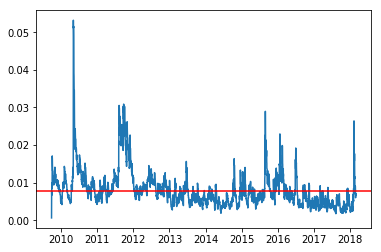

In [26]:
plt.plot(dailyVol)
plt.axhline(dailyVol.mean(), color = 'r')

In [27]:
# 3) Generación de la serie tEvents:
tEvents = getTEvents(close, dailyVol.mean())

In [28]:
# 4) Implementar la barrera vertical de salida:
t1 = addVerticalBarrier(tEvents, close, numDays = 1)

In [29]:
# 5) Generación de la serie "side" que define el la dirección a tomar en cada evento.
# Para este ejercicio la dirección de los eventos será determinada por el cruce de promedios móviles.

# Para crear los cruces de los promedios móviles, primero serán generadas las series de promedios móviles y luego con 
# estas series se evalúan las condiciones de los cruces.

fast_ma = 5
slow_ma = 13

price_df = (pd.DataFrame().assign(price = close)
            .assign(fast = close.ewm(fast_ma).mean())
            .assign(slow = close.ewm(slow_ma).mean()))


In [30]:
price_df.head()

,price,fast,slow
dates,,,
2009-09-28 09:53:49,51.138000,51.138000,51.138000
2009-09-28 10:06:04,51.190000,51.166364,51.164963
2009-09-28 10:19:50,51.210000,51.183626,51.181101
2009-09-28 10:32:01,51.379725,51.246752,51.236405
2009-09-28 10:53:46,51.330000,51.269949,51.257996


In [31]:
abc = pd.Series(index=close.index)

In [32]:
# Con las series fast y slow se genera la serie "side".

def ma_cross(fast, slow):
    #ma_cross = pd.Series(index=fast.index)
    
    up_cross = pd.Series(((fast.shift(1) < slow.shift(1)) & (fast > slow))*1,index=fast.index)
    down_cross = pd.Series(((fast.shift(1) > slow.shift(1)) & (fast < slow))*-1, index = fast.index)
    
    ma_cross = up_cross | down_cross
    #ma_cross = pd.concat([ma_cross[ma_cross == 1], ma_cross[ma_cross == -1]]).sort_index()
    
    
    return ma_cross
        

In [33]:
side = ma_cross(price_df.fast, price_df.slow)

In [34]:
side.shape

(30860,)

In [35]:
side = pd.concat([side[side == 1], side[side == -1]]).sort_index()

In [36]:
side.shape

(1088,)

In [37]:
side.head()

dates
2009-09-30 10:03:53   -1
2009-10-05 14:55:48    1
2009-10-20 14:04:34   -1
2009-10-21 10:57:04    1
2009-10-21 15:32:09   -1
dtype: int32

In [38]:
dailyVol.mean()

0.00768766790602776

In [39]:
# 6) Implementación de la triple barrera:
ptSl = [1,1]
trgt = dailyVol
minRet = dailyVol.mean()

events = getEvents2(close, tEvents, ptSl, trgt, minRet, t1=t1, side=side)

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [40]:
events.shape

(11165, 3)

In [41]:
events.head()

,side,t1,trgt
2009-10-01 13:33:25,NaN,2009-10-02 14:06:48,0.007945
2009-10-01 14:13:35,NaN,2009-10-02 14:58:19,0.008417
2009-10-01 14:52:25,NaN,2009-10-02 14:58:19,0.008722
2009-10-01 15:14:07,NaN,2009-10-02 15:20:42,0.008879
2009-10-01 15:30:21,NaN,2009-10-02 15:54:20,0.009027


In [42]:
# 7) Generación de la serie Bins:

ma_bins = getBins(events, close).dropna()

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sign


In [43]:
ma_bins.head()

,ret,bin
2009-10-05 14:55:48,0.015732,1.0
2009-10-20 14:04:34,-0.005601,0.0
2009-10-21 10:57:04,-0.012196,0.0
2009-10-21 15:32:09,0.009577,1.0
2009-10-29 15:30:16,-0.016903,0.0


In [44]:
ma_bins.shape

(332, 2)

In [45]:
features  = (pd.DataFrame()
          .assign(ma_side = side)
          .assign(volatilidad = dailyVol)
          .assign(ma_bins = ma_bins.bin)).dropna()

In [46]:
features.shape

(332, 3)

In [47]:
# Hasta ahora tenemos la matriz Y que está constituida por ma_bins y también tenemos la matrix X parcialmente constituida
# por la volatilidad diaria y por los cruces de promedios móviles; aún falta incluir la auto-correlación de la serie.

In [48]:
ret = returns(close)

In [49]:
window = 50
ret_corr = df_rolling_autocorr(ret, window, lag=1)

In [50]:
features['autocorrelation'] = ret_corr

In [51]:
features.head()

,ma_side,volatilidad,ma_bins,autocorrelation
dates,,,,
2009-10-05 14:55:48,1,0.013612,1.0,-0.144251
2009-10-20 14:04:34,-1,0.009998,0.0,-0.044208
2009-10-21 10:57:04,1,0.009836,0.0,-0.069374
2009-10-21 15:32:09,-1,0.009396,1.0,-0.008022
2009-10-29 15:30:16,1,0.011553,0.0,0.006693


In [52]:
# 8) Definición de la matriz X y Y:

In [53]:
X = features[['ma_side', 'volatilidad', 'autocorrelation']]            # DataFrame format
#X = features[['ma_side', 'volatilidad', 'autocorrelation']].vaX = features[['ma_side', 'volatilidad', 'autocorrelation']]   lues    # array format

In [54]:
y = features[['ma_bins']]           # DataFrame format
#y = features['ma_bins'].values     # array format

**7.2 a) Derive the performance from a 10-fold CV of an RF classifier on (X,y), with-out shuffling**

In [55]:
events['t1'][X.index].shape

(332,)

In [56]:
# inputs de la función cvScore():

events_t1 = events.loc[X.index, 't1']
sample_weights = pd.DataFrame({'weights':np.ones(len(y))/len(y)})

In [57]:
type(events_t1)

pandas.core.series.Series

In [58]:
estimators = 1000
clasificador_rf = RandomForestClassifier(n_estimators = estimators, max_depth = 2, criterion = 'entropy')

In [59]:
score_rf_NoShuffled = cvScore2_mc(clasificador_rf, X, y, sample_weights, scoring='neg_log_loss',\
                                t1 = events_t1, cv=10, cvGen=None, pctEmbargo=None)
score_rf_NoShuffled

array([-0.71558536, -0.71977402, -0.70993538, -0.66782194, -0.66703432,
       -0.68936296, -0.68255396, -0.71548605, -0.71262682, -0.66352822])

**b) Derive the performance from a 10-fold CV of an RF on (X,y), with shuffling.**

In [60]:
score_shuffled = cvScore_shuffled(clasificador_rf,X,y,sample_weights,scoring='neg_log_loss',t1=events_t1,
                                  cv=10,cvGen=None,pctEmbargo=None)
score_shuffled

array([-0.68584498, -0.68127397, -0.66756365, -0.72700833, -0.7125366 ,
       -0.71654737, -0.70479071, -0.70626808, -0.69198651, -0.68895541])

**c) Why are both results so different?**

Actually, the results are not so different.

**d) How does shuffling leak information?**

Source: Advances in Financial Machine Learning - 7.3 WHY K-FOLD FAILS IN FINANCE

Leakage takes place when the trainning set contains information that also appears in the testing set. Consider a serially correlated feature $X$ that is associated with labels $Y$ that are formed on overlapping data; by placing t and t+1 in different sets, information is leaked. This happens when a serially autocorrelated data set is shuffled.

# ----------------------------------------------------------------------------------------------------

#  

### Solution of the exercise 7.2 with the dollar_bar series fractionally differentiated:

In [61]:
# Following the steps of the exercise 5.5:

# The first step is to generate a serie with the cumulutative sum of the close logarithms
# This series must have DataFrame format in order to be accepted as input of the function fracDiff_FF() as is done next. 

close_log_df = pd.DataFrame(data=np.log(close).cumsum(), columns=['price'])
close_log_df.head()

,price
dates,
2009-09-28 09:53:49,3.934528
2009-09-28 10:06:04,7.870072
2009-09-28 10:19:50,11.806007
2009-09-28 10:32:01,15.745251
2009-09-28 10:53:46,19.683526


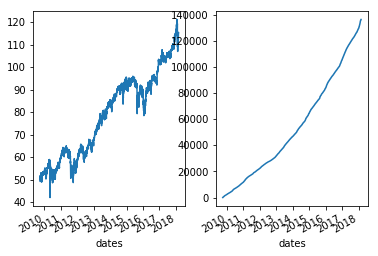

In [62]:
plt.subplot(1,2,1)
close.plot()

plt.subplot(1,2,2)
close_log_df['price'].plot()

In [63]:
# For the range of possible differentiation degree d∈ [0, 2] determine for what minimum d the new series is stationary.

d_vector = np.round(np.linspace(0,2,11),1)
thres = 1E-5

adf_pvalues = {}
close_FFD = {}
p_values_95 = {}

for d in d_vector:
    serie_d = pd.Series()
    serie_d = fracDiff_FFD(close_log_df, d, thres)      # The input "close_log_df" must be a DataFrame
    adf_test = adfuller(serie_d['price'], maxlag=1, regression='c', autolag=None)
    adf_pvalues[d] = adf_test[0]
    p_values_95[d] = adf_test[4]['5%']
    close_FFD[d] = serie_d

In [64]:
adf_df = pd.DataFrame(data = adf_pvalues, index = ['p_values'])
adf_pvalues = pd.DataFrame(data = p_values_95, index = ['p_95%'])

adf_results = pd.concat([adf_df, adf_pvalues], axis=0, join='outer')
adf_results

,0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0
p_values,2.965858,9.793015,30.679542,54.066429,30.397648,-1.555201,11.918647,9.277435,6.125229,3.483252,-139.450056
p_95%,-2.861634,-2.861645,-2.861638,-2.861635,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634


In [65]:
# The symmetric CUMSUM filter application - function getTEvents(gRaw, h)
# The gRaw serie is the cumulative sum of the close log fracDiff stationary series and h is the threshold to be overcome, 
# it is twice the standard deviation of the series. 

h_log = getDailyVol(close_log_df, span0=100)
h_log = h_log.mean()[0]

tEvents_log = getTEvents(close_log_df['price'], h_log)


In [66]:
#  

h = getDailyVol(close, span0=100).mean()

tEvents = getTEvents(close, h)

In [67]:
print(tEvents_log.shape)
print(tEvents.shape)

(30859,)
(28993,)


In [68]:
tEvents_log2, up, down = getTEvents2(close_log_df['price'], h_log)

In [69]:
print(f't_Events_log2.shape = {tEvents_log2.shape}')
print(f'up length = {len(up)}')
print(f'down length = {len(down)}')

t_Events_log2.shape = (30859,)
up length = 30859
down length = 0


In [70]:
# Generating fractionally differentiated series from close

In [71]:
close_df = pd.DataFrame(data=close, columns=['price'])

In [72]:
close_df.head()

,price
dates,
2009-09-28 09:53:49,51.138000
2009-09-28 10:06:04,51.190000
2009-09-28 10:19:50,51.210000
2009-09-28 10:32:01,51.379725
2009-09-28 10:53:46,51.330000


In [73]:
d_vector = np.round(np.linspace(0,2,11),1)
thres = 1E-5

adf_pvalues_close = {}
close_FFD_close = {}
p_values_95_close = {}

for d in d_vector:
    serie_d_close = pd.Series()
    serie_d_close = fracDiff_FFD(close_df, d, thres)      # The input "close_log_df" must be a DataFrame
    adf_test_close = adfuller(serie_d_close['price'], maxlag=1, regression='c', autolag=None)
    adf_pvalues_close[d] = adf_test_close[0]
    p_values_95_close[d] = adf_test_close[4]['5%']
    close_FFD_close[d] = serie_d_close

In [74]:
adf_df_close = pd.DataFrame(data = adf_pvalues_close, index = ['p_values'])
adf_pvalues_close = pd.DataFrame(data = p_values_95_close, index = ['p_95%'])

adf_results_close = pd.concat([adf_df_close, adf_pvalues_close], axis=0, join='outer')
adf_results_close

,0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0
p_values,-1.047943,-4.432380,-17.109613,-52.737981,-98.374261,-133.153601,-153.767509,-173.346231,-190.832968,-206.554131,-221.020097
p_95%,-2.861634,-2.861645,-2.861638,-2.861635,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634,-2.861634


In [75]:
close_diff02 = close_FFD_close[0.2]
close_diff06 = close_FFD_close[0.6]

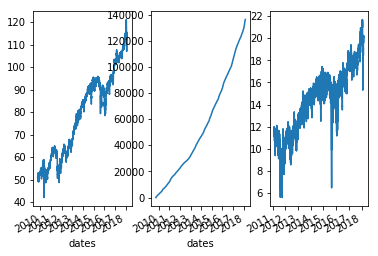

In [76]:
plt.subplot(1,3,1)
close.plot()

plt.subplot(1,3,2)
close_log_df['price'].plot()

plt.subplot(1,3,3)
close_diff02['price'].plot()

In [77]:
close.iloc[-5:]

dates
2018-02-26 15:31:06    115.29
2018-02-26 15:40:15    115.41
2018-02-26 15:49:42    115.20
2018-02-26 15:59:04    115.27
2018-02-26 16:16:14    115.30
Name: price, dtype: float64

In [78]:
close_diff02.iloc[-5:]

,price
2018-02-26 15:31:06,20.127724
2018-02-26 15:40:15,20.240256
2018-02-26 15:49:42,19.994914
2018-02-26 15:59:04,20.086267
2018-02-26 16:16:14,20.102956


In [79]:
close_diff06.iloc[-5:]

,price
2018-02-26 15:31:06,1.271880
2018-02-26 15:40:15,1.413352
2018-02-26 15:49:42,1.127147
2018-02-26 15:59:04,1.303219
2018-02-26 16:16:14,1.304422


In [80]:
close.index[-close_diff02.shape[0]:] - close_diff02.index

TimedeltaIndex(['0 days', '0 days', '0 days', '0 days', '0 days', '0 days',
                '0 days', '0 days', '0 days', '0 days',
                ...
                '0 days', '0 days', '0 days', '0 days', '0 days', '0 days',
                '0 days', '0 days', '0 days', '0 days'],
               dtype='timedelta64[ns]', length=27479, freq=None)

In [81]:
for d in close_FFD_close.keys():
    print(f'close_diff{d} shape = {close_FFD_close[d].shape}')


close_diff0.0 shape = (30860, 1)
close_diff0.2 shape = (27479, 1)
close_diff0.4 shape = (29403, 1)
close_diff0.6 shape = (30271, 1)
close_diff0.8 shape = (30633, 1)
close_diff1.0 shape = (30859, 1)
close_diff1.2 shape = (30768, 1)
close_diff1.4 shape = (30779, 1)
close_diff1.6 shape = (30799, 1)
close_diff1.8 shape = (30819, 1)
close_diff2.0 shape = (30858, 1)


In [82]:
for d in close_FFD_close.keys():
    print(f'w{d}.shape = {getWeights_FFD(d, 1E-5).shape}' )

w0.0.shape = (1, 1)
w0.2.shape = (3382, 1)
w0.4.shape = (1458, 1)
w0.6.shape = (590, 1)
w0.8.shape = (228, 1)
w1.0.shape = (2, 1)
w1.2.shape = (93, 1)
w1.4.shape = (82, 1)
w1.6.shape = (62, 1)
w1.8.shape = (42, 1)
w2.0.shape = (3, 1)


In [83]:
# Implementation of the triple barrier method

#def getEvents2(close, tEvents, ptSl, trgt, minRet, t1=False, side=None)


In [84]:
close02 = copy.deepcopy(close_diff02)

In [85]:
h02 = getDailyVol(close02, span0=100)
h02 = h02.mean()[0]

In [86]:
tEvents02 = getTEvents(close02['price'], h02)

In [87]:
tEvents02.shape

(21538,)

In [88]:
print(tEvents.shape)
print(tEvents_log.shape)
print(tEvents02.shape)

(28993,)
(30859,)
(21538,)


In [89]:
# The series to be used is the close02. It is the close fractionally differentiated with degree d=0.2.
# I decided not to use the cumulative sum of the logarithms of the close as mentioned in the exercise 5.5.a 
# because it is monotonic and the lowest differentiation degree that convert it stationary is d=2.0.


In [90]:
# Vertical Barrier implementation
t1_02 = addVerticalBarrier(tEvents02, close, numDays = 5)

# The vertical barrier is implemented using the timestamps from the fractionally differenciated series and with the 


In [91]:
# Triple Barrier Method

# For this case the series to be used to calculate the horizontal barriers (limit, stop) is the one without
# differentiation.


In [92]:
close_vol = getDailyVol(close, span0=100)

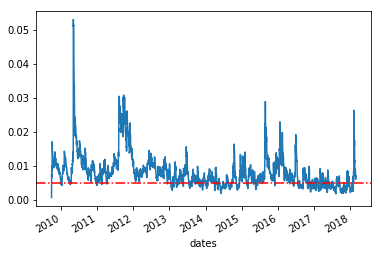

In [93]:
close_vol.plot()
plt.axhline(y=0.005, color='r', linestyle='-.')


In [94]:
# Generation of the series "side" which defines every event direction.
# To this exercise the event direction is defined by the moving average cross.

fast_ma = 5
slow_ma = 13 

In [95]:
# Before calculating the triple barrier method is it necessary to set the side of every event. 
# For this exercise it is subject to a moving average cross. The series used to calculate the
#  moving averages and their crosses is the differentiated one, close02.

price02_df = (pd.DataFrame()
             .assign(price02 = close02['price'])
             .assign(fast = close02.ewm(fast_ma).mean())
             .assign(slow = close02.ewm(slow_ma).mean()))


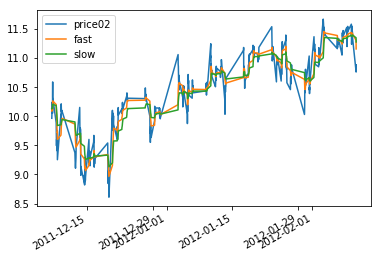

In [96]:
price02_df[2000:2500].plot()

In [97]:
side02 = ma_cross(price02_df.fast, price02_df.slow)

In [98]:
side02 = pd.concat([side02[side02==1], side02[side02==-1]]).sort_index()
side02.head()

2011-02-10 09:48:42   -1
2011-02-10 15:31:11    1
2011-02-11 09:29:59   -1
2011-02-11 11:03:01    1
2011-02-15 13:46:09   -1
dtype: int32

In [99]:
minRet = 0.005    # This value is taken based upon the daily volatility Non differentiated series plot (above).
ptSl = [2, 2]     # The limit and stop is set as twice the daily volatility.
trgt = close_vol  # This is the volatility of the close series. The limit and stop are based upon 
                  # the Non differentiated series.

In [100]:
# The series used as input in the getEvents2() function is "close" because within this function the limit and stop are set
# using the function applyPtSlOnT1(). It is done this way because it is more intuitive to set these values in terms of real 
# trading moves.

events02 = getEvents2(close, tEvents02, ptSl, trgt, minRet, t1=t1_02, side=side02)

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [101]:
events02.shape

(15041, 3)

In [102]:
events02.head()

,side,t1,trgt
2011-02-09 15:01:24,NaN,2011-02-14 15:14:30,0.007073
2011-02-09 15:11:52,NaN,2011-02-14 15:14:30,0.007048
2011-02-09 15:28:26,NaN,2011-02-14 15:34:02,0.007007
2011-02-09 15:32:25,NaN,2011-02-14 15:34:02,0.006991
2011-02-09 15:54:11,NaN,2011-02-15 09:31:09,0.006809


In [103]:
# Generation of the Bins
# The input price series is close (dollar_bar) because the function  getBins() determines if an event's return 
# was positive or negative setting 1 and 0 repectively.

ma_bins02 = getBins(events02, close).dropna()
ma_bins02.head()

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sign


,ret,bin
2011-02-10 09:48:42,-0.014035,0.0
2011-02-10 15:31:11,0.004897,1.0
2011-02-11 09:29:59,-0.012038,0.0
2011-02-11 11:03:01,0.007254,1.0
2011-02-15 13:46:09,-0.010705,0.0


In [104]:
ma_bins02.shape

(748, 2)

In [105]:
ma_bins02.head()

,ret,bin
2011-02-10 09:48:42,-0.014035,0.0
2011-02-10 15:31:11,0.004897,1.0
2011-02-11 09:29:59,-0.012038,0.0
2011-02-11 11:03:01,0.007254,1.0
2011-02-15 13:46:09,-0.010705,0.0


In [106]:
# Another explanatory feature is the series autocorrelation. It is calculated from the differentiated series.

window = 50
autocorr02 = df_rolling_autocorr(close02.price, window, lag=1).dropna() 

In [107]:
features02 = (pd.DataFrame()
             .assign(price02 = close02['price'])
             .assign(ma_side02 = side02)
             .assign(volatility = dailyVol)
             .assign(autocorr02 = autocorr02)
             .assign(ma_bins02 = ma_bins02['bin'])).dropna()

features02[features02['ma_bins02'] == 1].head()

,price02,ma_side02,volatility,autocorr02,ma_bins02
2011-03-10 10:00:11,10.457999,-1.0,0.007850,0.570806,1.0
2011-03-14 10:13:26,10.597094,-1.0,0.008836,0.687783,1.0
2011-03-17 09:33:33,10.842780,1.0,0.009157,0.375497,1.0
2011-03-23 15:09:17,11.142536,1.0,0.010439,0.753442,1.0
2011-04-07 13:42:55,11.355420,-1.0,0.005081,0.455763,1.0


In [108]:
features02.tail()

,price02,ma_side02,volatility,autocorr02,ma_bins02
2018-02-16 15:33:11,19.671651,-1.0,0.007693,0.838404,1.0
2018-02-21 15:05:35,18.872778,-1.0,0.007873,0.792798,0.0
2018-02-22 11:48:39,19.401527,1.0,0.007233,0.674147,1.0
2018-02-22 13:23:26,18.889633,-1.0,0.006984,0.670380,0.0
2018-02-23 10:13:26,19.097426,1.0,0.006691,0.785551,1.0


In [109]:
# Generation of the X and y matrices to set the training and test sets.

X02 = features02[['price02', 'ma_side02', 'volatility', 'autocorr02']]
y02 = features02[['ma_bins02']]

### K-Fold Cross-Validation

Once the features matrices are available the Cross-Validation is carried out through the function cvScore() 
which evaluates the performance for every set of the CV disposed by the class PurgeKFold().

Within the function cvScore() the fit() method and the log_loss() method require an input named "sample_weights" that is calculated through the function mpSampleW() which in turn asks a parameter numCoEvents that comes from the function mpNumCoEvents(). Then, the next step is to get these inputs to be able to implement the K-Fold Cross-Validation.

**NumCoEvents, sample_weights**

In [110]:
molecule02 = events02.index
numCoEvents02 = mpNumCoEvents(close.index, events02.t1, molecule02)

In [111]:
numCoEvents02.iloc[150:155]

dates
2011-02-24 12:39:41    35.0
2011-02-24 13:03:05    36.0
2011-02-24 13:34:49    37.0
2011-02-24 13:50:15    38.0
2011-02-24 13:54:19    38.0
dtype: float64

In [112]:
sample_weights02 = mpSampleW(events02.t1, numCoEvents02, close, molecule02)

**The Classifier:** 

In [113]:
avgU = mpSampleTW(events02.t1, numCoEvents02, molecule02)

In [114]:
clf = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample')

In [115]:
# bagging classifier
bc = BaggingClassifier(base_estimator = clf, n_estimators = 1000, max_samples = avgU.mean(), max_features = 1)

### cvScore():

**7.2 a) Derive the performance from a 10-fold CV of an RF classifier on (X,y), with-out shuffling**

In [116]:
kfolds = 10
embargo = 0

In [117]:
NoShuffled_score02 = cvScore2_mc(bc, X02, y02, sample_weights02, scoring='neg_log_loss', t1=events02.t1.loc[X02.index], cv=kfolds, cvGen=None, pctEmbargo=embargo)

In [118]:
NoShuffled_score02

array([-0.71402255, -0.67563599, -0.6834665 , -0.69763236, -0.70798166,
       -0.70005234, -0.68617447, -0.71617669, -0.68864216, -0.68968618])

In [119]:
NoShuffled_score02_mean = NoShuffled_score02.mean()
NoShuffled_score02_mean

-0.6959470900282814

**b) Derive the performance from a 10-fold CV of an RF on (X,y), with shuffling.**

In [120]:
shuffled_score02 = cvScore_shuffled(bc, X02, y02, sample_weights02, scoring='neg_log_loss', t1=events02.t1.loc[X02.index], cv=kfolds, pctEmbargo=embargo)

In [121]:
shuffled_score02

array([-0.69798087, -0.72029453, -0.68691291, -0.70690554, -0.67822255,
       -0.68774148, -0.68642062, -0.70110882, -0.70214714, -0.69462303])

In [122]:
shuffled_score02_mean = shuffled_score02.mean()
shuffled_score02_mean

-0.6962357478133601

**c) Why are both results so different?**

Although the differentiated series was included in many cases within the features, for instance, the moving averages crosses were generated upon the differentiated (d=0.2) series, the differentiated series (stationary) was used as a feature, and the autocorrelation was calucalated based on that series, the log_loss results from the Noshuffled and Shuffled KFold Cross-Validation are quite similar as opposed the author suggestion.

**d) How does shuffling leak information?**

Source: Advances in Financial Machine Learning - 7.3 WHY K-FOLD FAILS IN FINANCE

Leakage takes place when the trainning set contains information that also appears in the testing set. Consider a serially correlated feature $X$ that is associated with labels $Y$ that are formed on overlapping data; by placing t and t+1 in different sets, information is leaked. This happens when a serially autocorrelated data set is shuffled.

**7.3) Take the same pair of matrices (X,y) you used in exercised 2.**

**a) Derive the performance from a 10-fold purged CV of an RF on (X,y), with 1% embargo.**

In [123]:
embargo

0

In [124]:
# The matrices used previously are X02 y y02.

score_embargo = cvScore2_mc(bc, X02, y02, sample_weights02, scoring='neg_log_loss', t1=events02.t1.loc[X02.index], 
                            cv=kfolds, cvGen=None, pctEmbargo=embargo)

In [125]:
score_embargo

array([-0.72017909, -0.68121441, -0.69514632, -0.70252602, -0.71027406,
       -0.69582731, -0.68895095, -0.71662331, -0.68710929, -0.69902251])

**b) Why is the performance lower?**   
**c) Why is the result more realistic?**

The performance is similar to the previous 10-fold cross-validation. Intuitively it should be lower due to there is no information leakage.

**7.4) In this chapter we have focused on one reason why k-fold CV fails in financial applications, namely the fact that some information from the testing set leaks into the trainning set. Can you think of a second for CV's failure?**

One reason k-fold CV fails in finance is because observations cannot be assumed to be drawn from an IID process. A second reason for CV's failure is that the testing set is used multiple times in the process of developing a model, leading to multiple testing and selection bias.

source: Advances in Financial Machine Learning, section 7.3-WHY K-FOLD CV FAILS IN FINANCE.



**7.5) Suppose you try one thousand configurations of the same investment strategy, and perform a CV on each of them. Some results are guaranteed to look good, just by sheer luck. if you only publish those positive results, and hide the rest, your audience will not be able to deduce that these results are false positives, a statistical fluke. This phenomenon is called "selection bias".**

**a) Can you imagine one procedure to prevent this?**

A methodology called "Reality check" proposed by Halbert White - "A reality Check for Data Snooping" (2000).

"The idea is to generate the empirical distribution drom the full set of models (or trading strategies in this context) that lead to the best-performing strategy and to draw inferencefrom this distribution for certain performancemeasures."

Source: Technical Trading-Rule Profitability, Data Snooping, and Reality Check: Evidence from the Foreign Exchange Market, by MIN QI and YANGRU WU.

**b) What if we split the dataset in three sets: training, validation, and testing? The validation set is used to evaluate the trained parameters, and the testing is run only on the one configuration chosen in the validation phase. In what case does this procedure still fail?**

This can fail if the data set is shuffled generating information leakage. This takes place in a serially correlated feature  𝑋  that is associated with labels  𝑌  that are formed on overlapping data; by placing t and t+1 in different sets, information is leaked. 

Other situation that would make this procedure fail is the data mining bias. Even though the sets of variables is evaluated in a validation and test set it might not be statistically significant.

**c) What is the key to avoiding selection bias?**

Evaluate the results of the selected strategy (which is the one with best results) with an empirical distribution made from the results of the whole set of strategies. 